# Fully Connected Feedforward Neural Networks


<a href = "https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,3,3,2&seed=0.16617&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false">Click here</a> to go to pytorch's neural networks playground


## 1D Logistic Perceptron


### $f_{a, b}(x) = \sigma(a_0x[0] + a_1x[1] + ... + a_{d-1}x[d-1] + b)$

### $f_{a, b} = \sigma(a \cdot x + b)$

Logistic function

## $\sigma(u) = \frac{1}{1 + e^{-u}}$

We can only linearly separate with a single logistic perceptron, but we can use multiple logistic perceptrons together to select more complicated regions.  Here's a visual of this:

<img src = "TwoNeurons.svg" width="50%">

If we use at least three logistic perceptrons, we can separate an enclosed region.  To figure out what the weights should be, we use the fact that the vector of weights *a* represents the normal (perpendicular) to the direction of the line, and the number *b* is it distance to the origin:

<img src = "CircleSquareSeparate.svg" width="40%">

Let's look at this in code below:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

logistic = lambda u: 1/(1 + np.exp(-u))

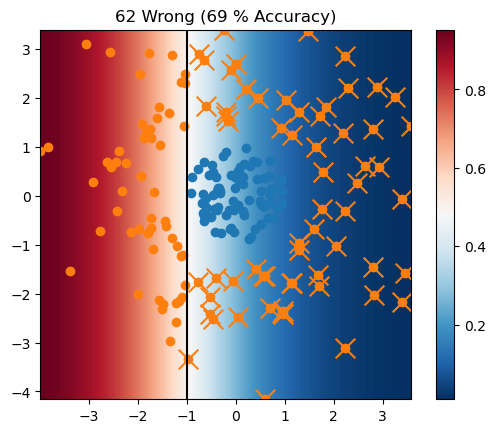

In [3]:
def plot_logistic_regression_predictions(X0, X1, A, B, thresh):
    plt.scatter(X0[:, 0], X0[:, 1])
    plt.scatter(X1[:, 0], X1[:, 1])
    X = np.concatenate((X0, X1), axis=0)
    xmin = np.min(X, axis=0)
    xmax = np.max(X, axis=0)
    iv = max(xmax[1]-xmin[1], xmax[0]-xmin[0])
    
    resol = 200
    mx = 2
    xx = np.linspace(xmin[0], xmax[0], resol)
    yy = np.linspace(xmin[1], xmax[1], resol)
    xx, yy = np.meshgrid(xx, yy)
    z = np.zeros_like(xx)
    for ab, c in zip(A, B):
        [a, b] = ab
        z += logistic(a*xx+b*yy+c)
    plt.imshow(z, extent=(xmin[0], xmax[0], xmax[1], xmin[1]), cmap='RdBu_r')#, vmin=0, vmax=1)
    plt.colorbar()
            
    wrong = 0
    for x in X0:
        y = 0
        for ab, c in zip(A, B):
            [a, b] = ab
            y += logistic(a*x[0] + b*x[1] +c)
        if y > thresh:
            plt.scatter([x[0]], [x[1]], 200, c='C0', marker='x')
            wrong += 1
    for x in X1:
        y = 0
        for ab, c in zip(A, B):
            [a, b] = ab
            y += logistic(a*x[0] + b*x[1] +c)
        if y <= thresh:
            plt.scatter([x[0]], [x[1]], 200, c='C1', marker='x')
            wrong += 1
    N = X.shape[0]
    
    # Plot separating lines
    for ab, c in zip(A, B):
        [a, b] = ab
        p0 = -c*np.array([a, b])/(a**2 + b**2)
        v = np.array([-b, a])
        mag = np.sqrt(np.sum(v**2))
        if mag > 0:
            v = v/mag
            p = p0 - 2*iv*v
            q = p0 + 2*iv*v
            plt.plot([p[0], q[0]], [p[1], q[1]], c='k')
    
    plt.xlim(xmin[0], xmax[0])
    plt.ylim(xmin[1], xmax[1])
    plt.title("{} Wrong ({} % Accuracy)".format(wrong, int(100*(N-wrong)/N)))
    
np.random.seed(0)

W = np.array([
    [-1, 0]
]) # Rows # of perceptrons, columns # of dimensions
B = np.array([-1]) # Rows # of perceptrons, 1 column 


X = np.random.randn(200, 2)
r = np.sqrt(np.sum(X**2, axis=1))
X[r > 1] *= 1.5
X0 = X[r <= 1, :]
X1 = X[r > 1, :]

plot_logistic_regression_predictions(X0, X1, W, B, thresh=0.5)

## Stringing Together Perceptrons (Neurons)

<a name = "goodfellow"><SUP>[1]</SUP></a> In what follows, I'll be mostly following notational conventions from <a href = "https://www.deeplearningbook.org/contents/mlp.html">Ch. 6.5 of <i>Deep Learning</i> by Goodfellow, Bengio, and Courville</a>

It's helpful to organize the weights of different nodes into matrices, as we did in the code above


<img src = "NetworkSnapshot.svg" width=200>

Let's also assume that the <b>i<SUP>th</SUP></b> orange node has a bias <b>b<SUB>i</SUB></b>.  Assuming that the activation function for the orange neurons is a function <b>f(u)</b>, then we could write the output of the <b>i<SUP>th</SUP> neuron as</b>



## $a[i] = w_{0i} x_0 + w_{1i} x_1 + w_{2i} x_2 + w_{3i} x_3 + b_i $
## $h[i] = f(a[i])  $


But there is a much more elegant way to write transformations for <b>all</b> inputs if we reformulate it as a matrix expression, and this will be much easier to implement in code.  In particular, define the following matrices 



## $W = \left[ \begin{array}{cccc}w_{00}&w_{10}&w_{20}&w_{30}\\w_{01}&w_{11}&w_{21}&w_{31}\\w_{02}&w_{12}&w_{22}&w_{32}\\w_{03}&w_{13}&w_{23}&w_{33}\\w_{04}&w_{14}&w_{24}&w_{34}\end{array}\right], x = \left[ \begin{array}{c} x_0 \\ x_1 \\ x_2 \\ x_3  \end{array} \right], b = \left[ \begin{array}{c} b_0 \\ b_1 \\ b_2 \\ b_3 \\ b_4 \end{array} \right]$




Then the output of a layer in the network can be defined in two stages



## $a = Wx + b$ , which is a linear operation
## $h = f(a)$, which is a nonlinear operation applied element-wise to $a$




In general, the parameters to map from the output of a layer with <b>N</b> neurons to the input of a layer with <b>M</b> neurons can be described by an <b>M x N</b> weight matrix <b>W</b> and an <b>Mx1</b> bias column vector <b>b</b>.  To propagate information through the whole network, we continually apply this sequence of linear and nonlinear operators in matrix form.  We just have to store the matrix <b>W</b>, the vector <b>b</b>, and the nonlinear function <b>f</b> that we're using at each layer.  And that's it!



In sum, below is pseudocode that describes how to do a forward pass to transform the input from each layer to the next through the entire network



<a name = "forwardalg">Algorithm 1: Forward Propagation Through A Fully Connected Feedforward Neural Network</a>
<h4>def forward(x)</h4>
<ul>
<li>Let <b>L</b> be the number of layers</li>
<li>Let <b>h<SUB>0</SUB> = x</b></li>
<li>
for <b>k = 1, 2, ..., L</b>
<ul>
<li>
Let <b>a<SUB>k</SUB> = W<SUB>k</SUB> h<SUB>k-1</SUB> + b<SUB>k</SUB></b> // Linear step. The input to this layer, h<SUB>k-1</SUB>, is the output of the last layer
</li>
<li>
Let <b>h<SUB>k</SUB> = f(a<SUB>k</SUB>)</b> // Nonlinear step
</li>
</ul>
</li>
<li>
<b>y<SUB>est</SUB> = h<SUB>L</SUB></b> // The output of the last layer is the output of our network
</li>
</ul>


## Alternative Nonlinear Functions

In addition to the logistic function, there are several other functions that are commonly used as activation functions to which the output of $Wh + b$ is fed.  Below are a few examples

Text(0.5, 1.0, 'Hyperbolic Tangent')

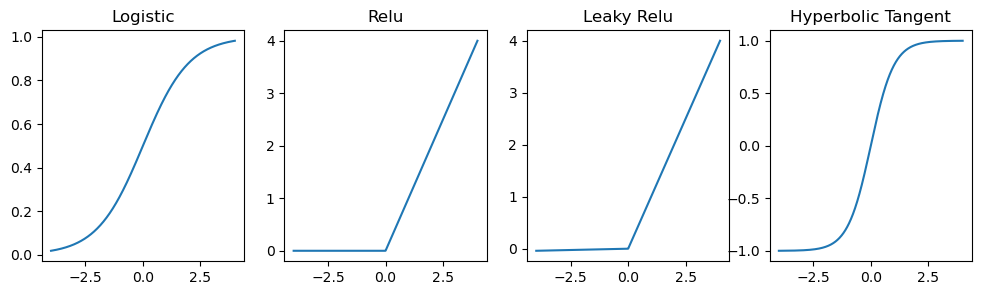

In [3]:
def relu(u):
    ret = np.array(u)
    ret[ret < 0] = 0
    return ret

def lrelu(u, eps=0.01):
    ret = np.array(u)
    ret[ret < 0] *= eps
    return ret

htan = lambda u: (np.exp(2*u)-1)/(np.exp(2*u)+1)

u = np.linspace(-4, 4, 1000)

plt.figure(figsize=(12, 3))
plt.subplot(141)
plt.plot(u, logistic(u))
plt.title("Logistic")
plt.subplot(142)
plt.plot(u, relu(u))
plt.title("Relu")
plt.subplot(143)
plt.plot(u, lrelu(u))
plt.title("Leaky Relu")
plt.subplot(144)
plt.plot(u, htan(u))
plt.title("Hyperbolic Tangent")